# * # Ship detection by PyTorch segmentation****

** Overview **
> 
> in this notebook we use pytorch segmentation library  :
> https://github.com/qubvel/segmentation_models.pytorch 
> 
> proved awsome pretrain networks of segmentation , we check two networks Unet and FPN and comparing two of us to get better results . 
> both networks have backbone of resnet50 and training a 20 ephoces .
> we used only 1000 examples , for train and validation beacuse the training take a lot time , maybe we get same results with less data !
> 

In [2]:
#requirements 
!pip install segmentation_models_pytorch

     |████████████████████████████████| 97 kB 262 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 841 kB/s eta 0:00:01
     |████████████████████████████████| 376 kB 847 kB/s eta 0:00:01
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=3dc96d2e3df348204dd8b9bd9e876e8309fe09013e59351d82f8bf932cf864a0
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=03522e0f94588f83d46bd0c7cab40e63ebd19444e95572d2b949181cfed411ae
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built pretrainedmodels efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from PIL import Image
import time
from skimage.morphology import binary_opening, disk, label

In [4]:
import segmentation_models_pytorch as smp

In [6]:
# df_segment = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
# img_masks = df_segment.loc[df_segment['ImageId'] == '000155de5.jpg', 'EncodedPixels'].tolist()
# all_masks = 

1

In [5]:
#create dataset
class ShipDatabaseSegmation(torch.utils.data.Dataset):
    def __init__(self,in_df,root_path,transforms=None):
        imagesIds = in_df['ImageId'].tolist()
        self.image_ids =  list(set(imagesIds))
        self.in_df = in_df
        self.root_path = root_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self,idx):
        ImageId = self.image_ids[idx]
        img = Image.open(self.root_path + "/"+ ImageId)
        img_masks = self.in_df.loc[self.in_df['ImageId'] == ImageId, 'EncodedPixels'].tolist()
        all_masks = np.zeros((768, 768))
        
        
        #all_masks = np.expand_dims(all_masks,axis=0)
        if self.transforms is not None:
            img = self.transforms(img)
            all_masks = self.transforms(all_masks)

        return img,all_masks

In [13]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [14]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [15]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros([shape[0]*shape[1],1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [16]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Preproccessing the data

In [17]:
submission = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
submission = submission.dropna()
submission.head()

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


# Split train and valid

In [18]:
unique_img_ids = submission.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )

train_df = pd.merge(submission, train_ids)
valid_df = pd.merge(submission, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

77636 training masks
4087 validation masks


In [19]:
# #take only 1000 ( maybe with less examples we can get same results)
train_df = train_df[:1000]
valid_df = valid_df[:1000]

In [20]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor() 
])

ship_dataset_train = ShipDatabaseSegmation(train_df,"../input/airbus-ship-detection/train_v2",transforms=transforms)
ship_dataset_valid = ShipDatabaseSegmation(valid_df,"../input/airbus-ship-detection/train_v2",transforms=transforms)

train_loader = torch.utils.data.DataLoader(ship_dataset_train, batch_size=5, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(ship_dataset_valid, batch_size=1, shuffle=False, num_workers=4)

# **How our data look likes**

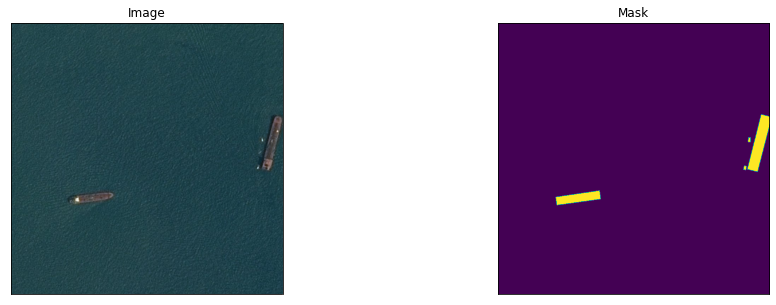

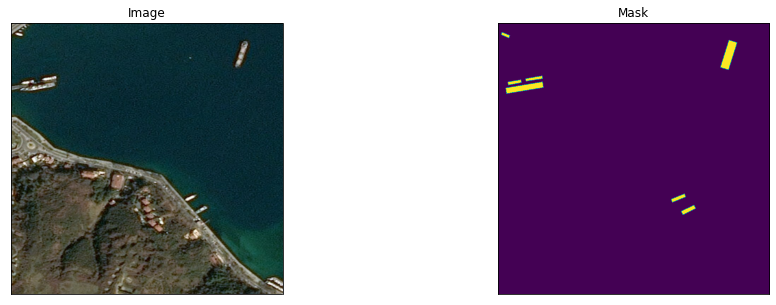

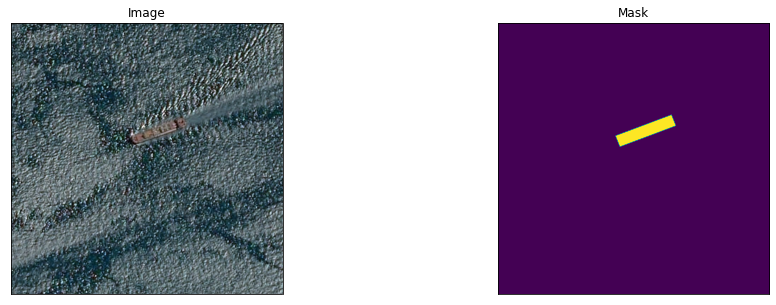

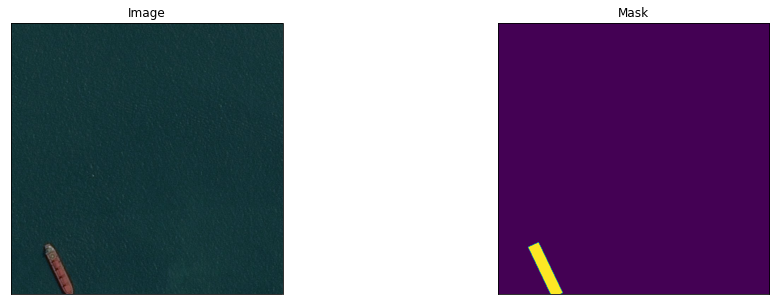

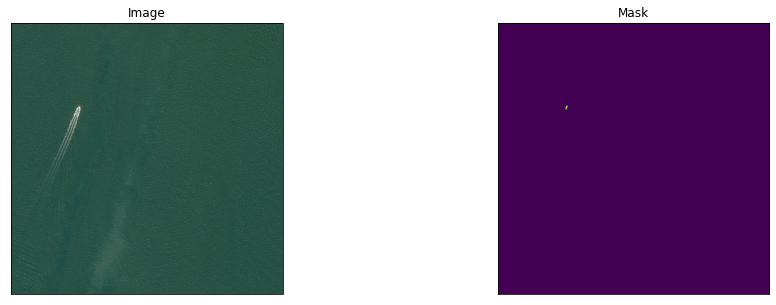

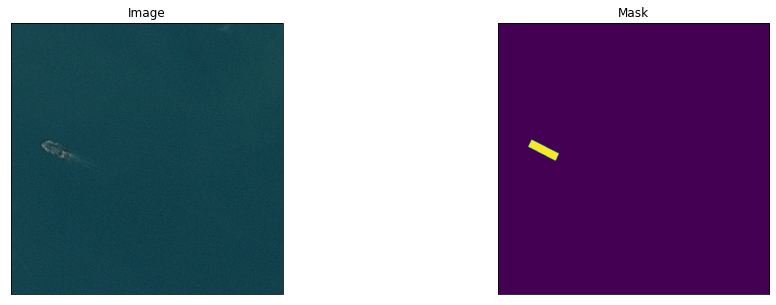

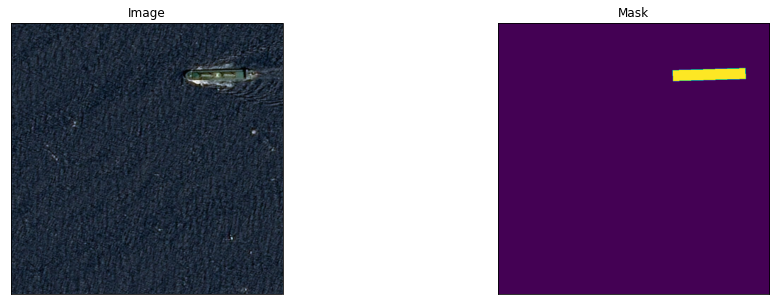

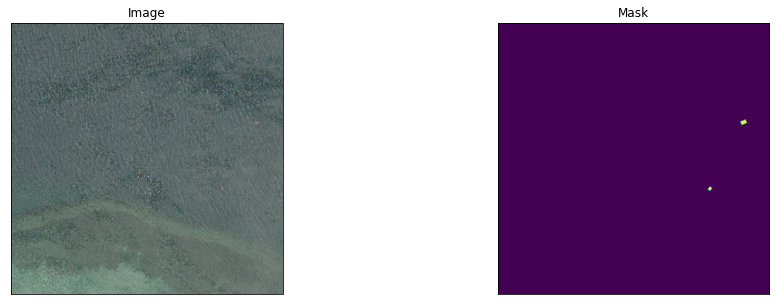

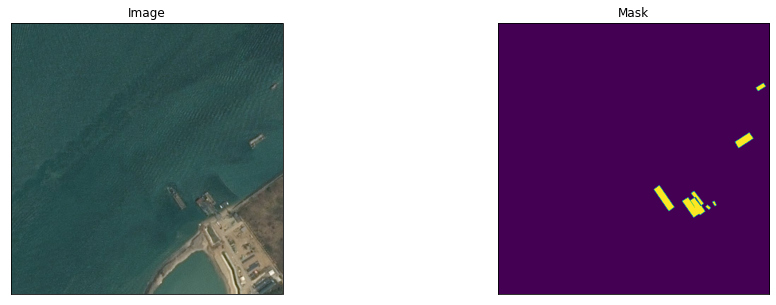

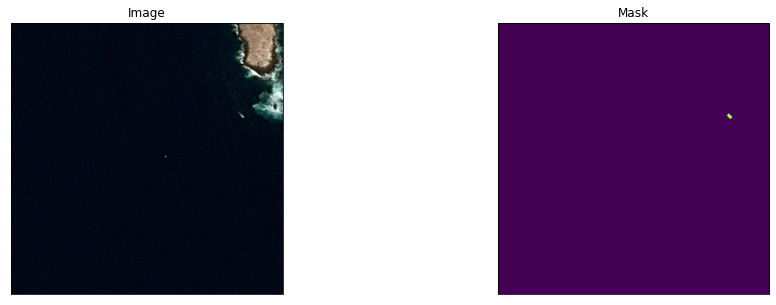

In [45]:
examples = iter(valid_loader)
for i in range(10):
    img,mask = next(examples)
    visualize(
    image=img.squeeze().permute(1,2,0),
    mask = mask.squeeze(),
    )

# Train section

overview about train section

In [22]:
from segmentation_models_pytorch import utils

In [23]:
loss = nn.BCEWithLogitsLoss()
loss.__name__ = "bceWithLogitLoss"

device = "cuda"
metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
    smp
]

In [24]:
def train(model,number_epoches,model_name,device='cuda',lr=0.0001):
    optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=lr),])

    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
    print("Start train model : ",model_name)
    
    max_score = 0
    for i in range(0, number_epoches):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './'+model_name+'_best_model.pth')
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')
        if i % 5 == 0:
            torch.save(model, './'+model_name+'_epoch_'+str(i)+'_'+str(time.time())+'.pth')
            print("save model !")
    
    

In [25]:
encoder = 'resnet50'
encoder_weights ='imagenet'
number_epoches = 20
device = 'cuda'
lr = 0.0001
Unet = smp.Unet(encoder,encoder_weights=encoder_weights)
FPN = smp.FPN(encoder,encoder_weights=encoder_weights)


for model_name,model in zip(["Unet","FPN"],[Unet,FPN]):
    train(model,number_epoches,model_name,device=device,lr=lr) # train take 1 hour and half each model so in commands for submit


AttributeError: module 'segmentation_models_pytorch' has no attribute 'to'

# Testing and comparing models 

In [ ]:
FPN = torch.load("../input/ship-detection-unet-fpn/FPN_best_model.pth")
Unet = torch.load("../input/ship-detection-unet-fpn/Unet_best_model.pth")

In [ ]:
test_epoch_FPN = smp.utils.train.ValidEpoch(
        FPN, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
test_epoch_Unet = smp.utils.train.ValidEpoch(
        Unet, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )

**Check iou score between models**

In [ ]:
valid_logs = test_epoch_FPN.run(valid_loader) #  on data validation
train_logs = test_epoch_FPN.run(train_loader) #  on data train

In [ ]:
valid_logs = test_epoch_Unet.run(valid_loader) # on data validation
train_logs = test_epoch_Unet.run(train_loader) # on data train

> both models have  +- same iou score but Unet have a little better result so we will take him for test.

# Results model Unet visualize

In [ ]:
valid_loader = torch.utils.data.DataLoader(ship_dataset_valid, batch_size=1, shuffle=False, num_workers=4)
test = iter(valid_loader)

for i in range(30):
    img,mask = next(test)
    pred = Unet(img.cuda())
    pred = pred.detach().cpu().double()
    visualize(
    image=img.squeeze().permute(1,2,0),
    mask = mask.squeeze(),
    Predict=pred.squeeze(),
    )

# Submission 

In [ ]:
def pred_image_from_path_encode(root_path,image_names,model,device):
    out_pred_rows = []
    for img_name in image_names:
        c_img = Image.open(root_path+"/"+img_name)
        covnertTensor = torchvision.transforms.transforms.ToTensor()
        c_img = covnertTensor(c_img)
        c_img = c_img.unsqueeze(0)
        if device == 'cuda':
            c_img = c_img.cuda()
        cur_seg = model(c_img)
        cur_seg = cur_seg.squeeze(0).squeeze(0).detach().cpu().numpy()
        cur_seg[cur_seg < 0.5] = 0 
        cur_seg[cur_seg >= 0.5] = 1
        cur_rles = multi_rle_encode(cur_seg,max_mean_threshold=1.0)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                out_pred_rows += [{'ImageId': img_name, 'EncodedPixels': c_rle}]
        else:
            out_pred_rows += [{'ImageId': img_name, 'EncodedPixels': None}]
    
    return out_pred_rows
    



In [ ]:
test_image_dir = "../input/airbus-ship-detection/test_v2"
images_names = np.array(os.listdir(test_image_dir))
print(images_names)
print(len(images_names), 'test images found')
out_pred_rows = pred_image_from_path_encode(test_image_dir,images_names[:200],Unet,device)
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]


In [ ]:
sub.head(5)

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
# validation submission.csv

In [ ]:
submission = pd.read_csv('./submission.csv')
submission = submission.dropna()
submission.head()

In [ ]:


dataset_test = ShipDatabaseSegmation(submission,"../input/airbus-ship-detection/test_v2",transforms=transforms)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=8)


In [ ]:
examples = iter(test_loader)

for img,mask in examples:
    visualize(
    image=img.squeeze().permute(1,2,0),
    predict = mask.squeeze(),
    )